<a href="https://colab.research.google.com/github/RaminParker/Deep-Learning-image-classification/blob/master/Image_classification_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What's your pet

We will build our first image classifier from scratch, and see if we can achieve world-class results. 

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

### Settings

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

To update packages and the course repo:

In [23]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0   6829      0 --:--:-- --:--:-- --:--:--  6829
Updating fastai...
Done.


We import all the necessary packages. We are going to work with the fastai V1 library which sits on top of Pytorch 1. 

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

### Saving your data files

If you run a script which creates/ downloads files, the files will NOT persist after the allocated instance is shutdown. To save files, you need to permit your Colaboratory instance to read and write files to your Google Drive. Add the following code snippet at the beginning of every notebook.

In [48]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [49]:
base_dir

'/content/gdrive/My Drive/fastai-v3/'

Now, you may access your Google Drive as a file sytem using standard python commands to both read and write files.

In [28]:
!ls

data  gdrive  models


## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/)  which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. 

According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [29]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



See what we have just downloaded:

In [30]:
path = untar_data(URLs.PETS)
path

PosixPath('/content/data/oxford-iiit-pet')

In [31]:
path.ls()

[PosixPath('/content/data/oxford-iiit-pet/images'),
 PosixPath('/content/data/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

**How our labels look like?**
Check how the data directories are structured, what the labels and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [33]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/content/data/oxford-iiit-pet/images/beagle_127.jpg'),
 PosixPath('/content/data/oxford-iiit-pet/images/basset_hound_173.jpg'),
 PosixPath('/content/data/oxford-iiit-pet/images/scottish_terrier_158.jpg'),
 PosixPath('/content/data/oxford-iiit-pet/images/scottish_terrier_197.jpg'),
 PosixPath('/content/data/oxford-iiit-pet/images/Birman_14.jpg')]

This regex pattern will give us a string (the label) of the path variables.

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

Loads the train, val & test data and applies transformations.

To open up class documentation and source use doc function.

ds_tfms is transformations which we will be applying to images on the fly. transforms also changes all the image sizes to 224 X 224 since on these sizes our architecture resnet34 has been trained on. Also, all the images get centered, cropped and zoomed a little bit by transformation functions.

from_name_re() is a factory method to extract labels using regular expressions


In [0]:
# doc(ImageDataBunch)
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

**Question: Why is normalization important?**
Pixel values of images range from 0 to 255. Images generally contain 3 color channels (Red, Green, and Blue). Sometimes some channels will be bright, some might be dull. Some might vary so much and some might not vary at all. It really helps to train a model if all those 3 channels have got pixel values with a mean of 0 and a standard deviation of 1. Normalization simply does that.

**Question: Why do we set image size?**
A GPU has to apply the excact same functions to the data in order to be fast. If the images are different shape and sizes, the GPU can't do that.

**Question: As GPU mem will be in power of 2, doesn’t size 256 sound more practical considering GPU utilization compared to 224?**
The brief answer is that the models are designed so that the final layer is of size 7 by 7, so we actually want something where if you go 7 times 2 a bunch of times (224 = 72222*2), then you end up with something that’s a good size.


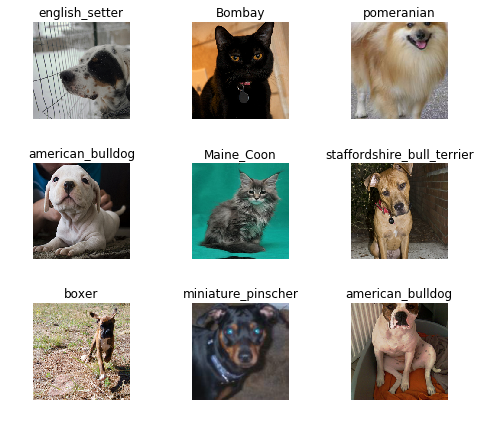

In [36]:
data.show_batch(rows=3, figsize=(7,6))

List down all the classes you have and check the total number of classes.

We have indeed 37 classes in oxford pet dataset.
the data.c property also gives the number of classes.

In [37]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier.The model will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

**Why resnet34?**

https://forums.fast.ai/t/why-resnet34-in-lesson-1/24647

Resnet34 has 34 layers, resnet50 has 50 layers.

**Training a model using resnet architecture** [35:05]

Training means creating a set of weights. it.e, finding a set of coefficients in case of linear or logistic regression.

Resnet works well with almost all the image classification problems, you need to just care about how big architecture is.
In resnet34, 34 signifies a number of layers in model architecture.

create_cnn method resides in fastai.vision.learner class.
In fastai, the model is trained by a learner, create_cnn takes few parameters, first the DataBunch data object, then model resnet34, the last thing to pass is the list of metrics.

When you call create_cnn first time, it downloads resnet34 pre-trained weights.

Pre-trained means this particular model has been already trained for the particular task, and that task is it is been trained on 1 and half million pictures of 1000 different categories of objects like plants, animals, people, cars etc. using image dataset called Imagenet 7.

So we don’t necessarily start with a model that knows nothing about images, but we start with knowledge of images of 1000 categories.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

**Applying One Cycle Policy**

fit_one_cycle method fits a model following one cycle policy.
It accepts cycle_len which is an integer describing how many times you want to pass through the complete dataset. Each time model sees a picture, it keeps getting better. It gonna take a lot of time. But if you show images too many times, the model will learn to recognize that image alone. In machine learning, this is called overfitting. (memorizing).
max_lr is maximum learning rate, moms are momentum and wd is weight decay we will learn about all these parameters in subsequent lectures.

In [39]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.893338,0.332350,0.098106,01:19


In [0]:
learn.export(file='testxxx.pkl')

In [41]:
path = learn.path
path

PosixPath('/content/data/oxford-iiit-pet/images')

In [0]:
#learn = load_learner(path, 'testxxx.pkl')
learn = load_learner('/content/data/oxford-iiit-pet/images', 'testxxx.pkl')

In [0]:
# os.listdir('.')

In [0]:
# !ls

In [0]:
# # Load the Drive helper and mount
# from google.colab import drive
# drive.mount('/content/drive')

In [37]:
# !pip install -U -q PyDrive

     |████████████████████████████████| 993kB 4.9MB/s 


In [0]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # 1. Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)  

# # get the folder id where you want to save your file
# file = drive.CreateFile({'parents':[{u'id': models}]})
# file.SetContentFile('testxxx.pkl')
# file.Upload() 

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# root_dir = "/content/gdrive/My Drive/"
# os.listdir(root_dir)

In [0]:
# def custom_path_save(self, name:PathOrStr, path='', return_path:bool=False, with_opt:bool=True):
#         "Save model and optimizer state (if `with_opt`) with `name` to `self.model_dir`."
#         # delete #  path = self.path/self.model_dir/f'{name}.pth'
#         # my addition: start
#         if path=='': path = self.path/self.model_dir/f'{name}.pth'
#         else: path = f'{path}/{name}.pth'
#         # end
#         if not with_opt: state = get_model(self.model).state_dict()
#         else: state = {'model': get_model(self.model).state_dict(), 'opt':self.opt.state_dict()}
#         torch.save(state, path)
#         if return_path: return path

# def custom_path_load(self, name:PathOrStr, path='', device:torch.device=None, strict:bool=True, with_opt:bool=None):
#         "Load model and optimizer state (if `with_opt`) `name` from `self.model_dir` using `device`."
#         if device is None: device = self.data.device
#         # delete # state = torch.load(self.path/self.model_dir/f'{name}.pth', map_location=device)
#         # my addition: start
#         if path=='': path = self.path/self.model_dir/f'{name}.pth'
#         else: path = f'{path}/{name}.pth'
#         state = torch.load(path, map_location=device) 
#         # end
#         if set(state.keys()) == {'model', 'opt'}:
#             get_model(self.model).load_state_dict(state['model'], strict=strict)
#             if ifnone(with_opt,True):
#                 if not hasattr(self, 'opt'): opt = self.create_opt(defaults.lr, self.wd)
#                 try:    self.opt.load_state_dict(state['opt'])
#                 except: pass
#         else:
#             if with_opt: warn("Saved filed doesn't contain an optimizer state.")
#             get_model(self.model).load_state_dict(state, strict=strict)
#         return self

# learn.save = custom_path_save.__get__(learn)
# learn.load = custom_path_load.__get__(learn)
# # if you don't want to overload
# #learn.custom_path_save = custom_path_save.__get__(learn)
# #learn.custom_path_load = custom_path_load.__get__(learn)


# model_path = '/content/gdrive/My Drive/fastai-v3/data/'
# model_path = '/Computers/My Laptop/Documents/tutorials/fastai/course-v3'
# learn.save('new-model-name', path=model_path)
# learn.load('new-model-name', path=model_path)

In [0]:
#!pip freeze

**Saving model weights**

This step is very important as you may need to reload your weights next time you run the code.

This will save the model as .pth format, which is Pytorch’s default serialization method.
Models will get saved into your local dir in /models folder
Since different model’s weights should be saved separately we use local directories instead of a global one.

If we want to play around more with hyperparameters, we should save weights.

In [0]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which categories the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

**Plot top losses**

We will learn about loss functions shortly. But the idea is loss function tells you how good was your prediction compared to ground truth.
Specifically, that means if you predicted one class of cat with great confidence.
For example, if you confidently predicted this is a Berman cat, but actually it was wrong. It was a Ragdoll cat. Then it is going to have a very high loss because you were very confident about the wrong answer.
So by plotting the top losses, we are going to plot images which were most confident about the prediction but were wrong.

These are a prediction, actual, loss, the probability of actual class.

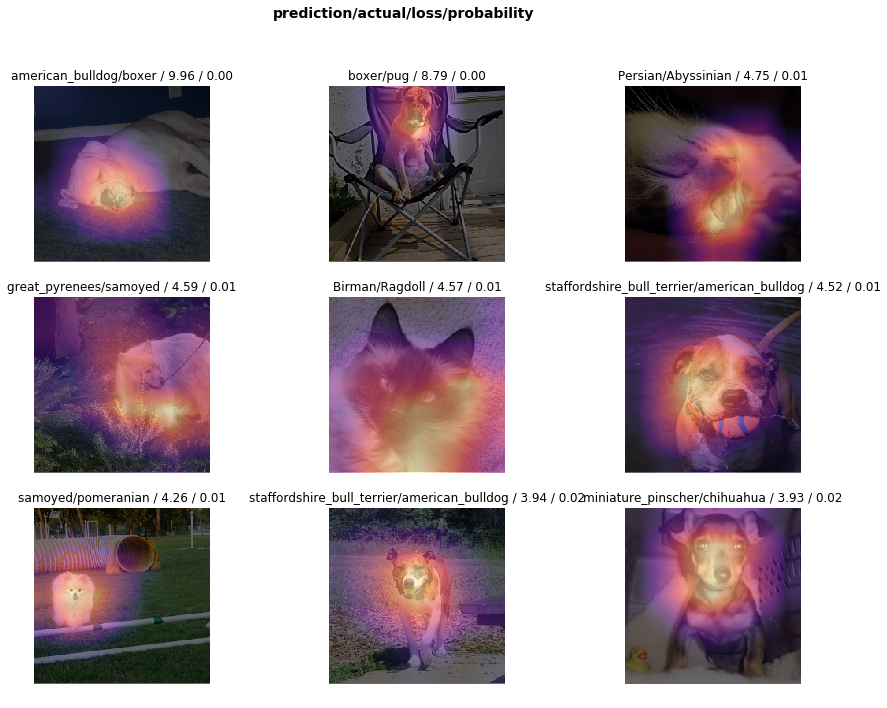

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
# doc(interp.plot_top_losses)

**Confusion Matrix**

It shows you for every actual type dog or cat, how many time model predicted to be of that dog or cat.
Because it’s pretty accurate this time it shows darker diagonal line, with little lighter numbers for some other wrong combinations.
If you have got lots of classes, don’t use a confusion matrix. instead, use named function by fastai called most_confused().

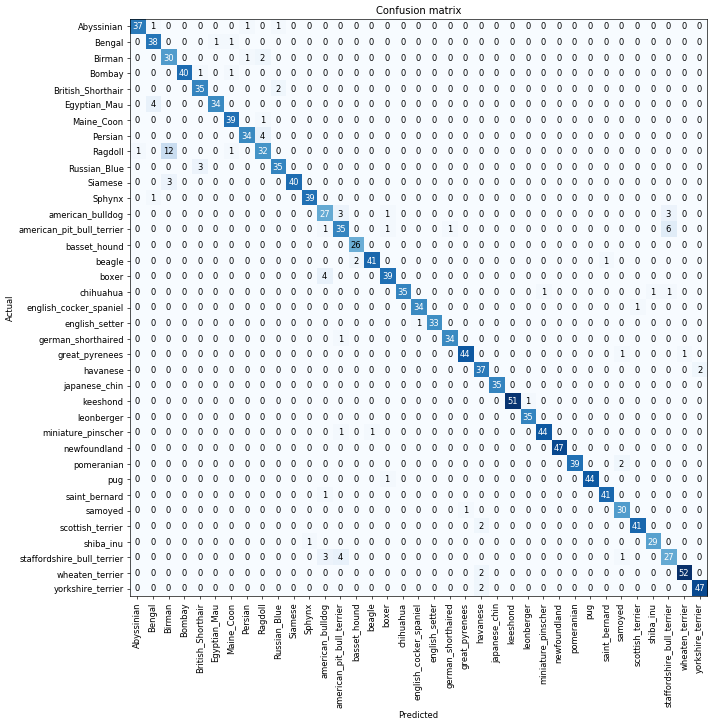

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

**Most confused categories**

most_confused() function will simply grab out of the confusion matrix the most confused combinations of predicted and actual categories, that it got wrong most often.

In [0]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 12),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Persian', 'Ragdoll', 4),
 ('boxer', 'american_bulldog', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('Siamese', 'Birman', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('Birman', 'Ragdoll', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('beagle', 'basset_hound', 2),
 ('havanese', 'yorkshire_terrier', 2),
 ('pomeranian', 'samoyed', 2),
 ('scottish_terrier', 'havanese', 2),
 ('wheaten_terrier', 'havanese', 2),
 ('yorkshire_terrier', 'havanese', 2)]

## Unfreezing, fine-tuning, and learning rates

**Making model Better**

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

We can make our model better by Fine-tuning
So far we have fitted 4 epochs and it ran pretty quickly. Why is that so? Because we used a little trick (called transfer learning).
These deep learning models have many layers. We will learn later about what layers are. But for now, understand that it goes through a lot of computations.

What did we do?
We added few extra layers at the end of architecture, and we only trained those. we left most of the early layers as they were. This is called freezing layers i.e weights of the layers. So that was really fast.

If we want to build a model, that is quite similar to the original retrained model, in this case, similar to Imagenet data that works pretty well.

What we really want to do?
To go back and train the whole model. So this is why we always use this 2-state process.

when we call fit or fit_one_cycle() on a create_cnn, it will just fine tune these extra layers at the end, and run very fast.
It will basically never overfit, but to really get it good, you have to call learn.unfreeze() . It says train the whole model.

In [0]:
learn.unfreeze()

Then again we have to call fit_one_cycle() but the error we got now is much worse.

**Why has that happened?**

There is a deep reason behind it. It is important to understand. Read here [Visualizing layers of the convolutional model](https://forums.fast.ai/t/deep-learning-lesson-1-notes/27748) or watch [1:16:00]

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.518778,0.354021,0.108254,01:27


**Load the weights**

Let’s load the weights of the model we saved earlier as stage-1.

So now our model is back to where it was before we killed it.

In [0]:
learn.load('stage-1');

**Find the learning rate**

Let’s run learning rate finder. 
This is the thing that figures out what is the fastest I can train this neural network without making it zip off the rails and get blown apart.

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


 Plot the results 

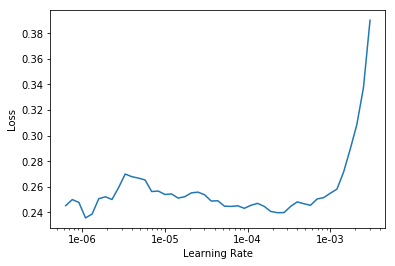

In [0]:
learn.recorder.plot()

This will plot the result of our LR finder and what this basically shows you is the key parameter called a learning rate. The learning rate basically says how quickly are we updating the parameters in our model. The x-axis one here shows me what happens as I increase the learning rate. The y-axis shows what the loss is. So you can see, once the learning rate gets passed 10-4, our loss gets worse. We can check this by pressing shift+tab in the fit_one_cycle() function, to see that our learning rate default is set to 0.003 = 10-3. 

This is why our loss got much worse. Because we are trying to fine-tune things now, we can’t use such a high learning rate. So based on the learning rate finder, we have to pick a new learning rate. But there’s no point training all the layers at that rate because we know that the later layers worked just fine before when we were training much more quickly. So what we can actually do is we can pass a range of learning rates to learn.fit_one_cycle. And we do it like this:

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.157381,0.182002,0.062923,01:26
1,0.141719,0.181964,0.058187,01:26
2,0.129214,0.182540,0.060217,01:26


You use this keyword in Python called slice and that can take a start value and a stop value and basically what this says is train the very first layers at a learning rate of 1e-6, and the very last layers at a rate of 1e-4, and distribute all the other layers across that between those two values equally.

**Rule of thumbs**

*  We used 1e-4 because we want to be about 10 times smaller than what we started with (which was the default 1e-3) 

*  We used 1e-6 because we want to be well before things started getting worse (which is about at the the LR 10e-4)


## Training: resnet50

Now we will train in the same way as before but with one change: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers.

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

What you’ll find is it’s very likely if you try to do this, you will get an error and the error will be your **GPU has run out of memory**. The reason for that is that ResNet50 is bigger than ResNet34, and therefore, it has more parameters and uses more of your graphics card memory, just totally separate to your normal computer RAM, this is GPU RAM. 

If your have less than 8G of GPU memory, it’s going to be frustrating for you!

It’s very likely that if you try to run this, you’ll get an out of memory error and that’s because it’s just trying to do too many parameter updates for the amount of RAM you have. That’s easily fixed. ImageDataBunch constructor has a parameter at the end bs i.e a batch size. This basically says **how many images do you train at one time.** If you run out of memory, just make it smaller. bs=48 should work for on 8G card. If it doesn’t work, just  decrease the batch size to 32 or less than that.

It’s fine to use a smaller batch size. It might **take a little bit longer**. That’s all.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:00, 119752472.71it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


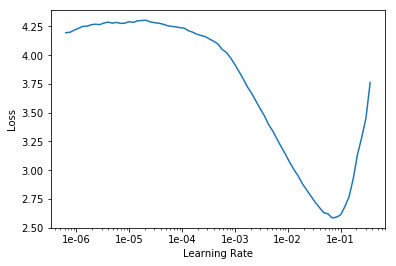

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.720348,0.270339,0.079161,02:16
1,0.410861,0.268290,0.092016,02:09
2,0.348481,0.236333,0.075101,02:11
3,0.270259,0.196889,0.063599,02:11
4,0.217334,0.195204,0.066306,02:08
5,0.175951,0.190640,0.060217,02:11
6,0.119490,0.166021,0.054804,02:07
7,0.096001,0.161571,0.049391,02:11


In [0]:
learn.save('stage-1-50')

 Let's see if full fine-tuning helps:

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


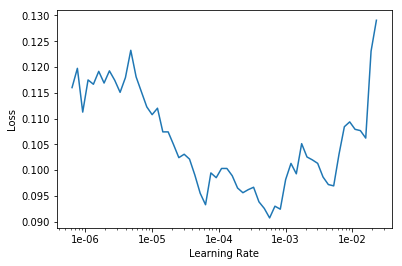

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.104583,0.166309,0.053451,02:22
1,0.097577,0.160007,0.052097,02:18
2,0.086713,0.156737,0.051421,02:21


If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Birman', 'Ragdoll', 4),
 ('Ragdoll', 'Birman', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Ragdoll', 'Persian', 3),
 ('Sphynx', 'chihuahua', 3),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Maine_Coon', 'Persian', 2),
 ('Ragdoll', 'Siamese', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('basset_hound', 'beagle', 2),
 ('boxer', 'american_bulldog', 2),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 2)]

## Other data formats

In [0]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

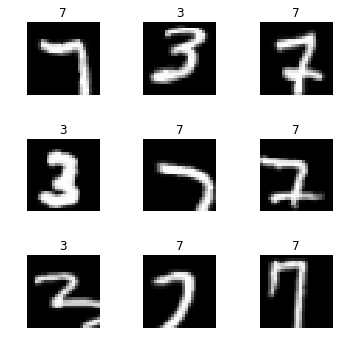

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [0]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

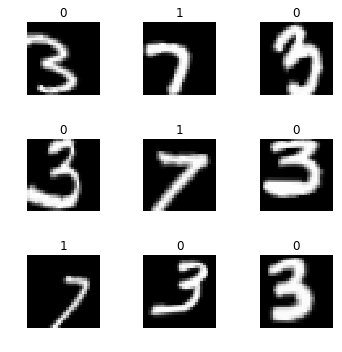

In [0]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [0]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [0]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [0]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [0]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [0]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']